In [2]:
import os
import glob
import pandas as pd
from Bio import SeqIO
from collections import defaultdict
import matplotlib.pyplot as plt
import math
import numpy as np

In [ ]:
# Generate files for each protein containing the IDs of sequences that did not align,
# as well as the total number of initial sequences,
# the number of sequences that did not align,
# and the number of sequences that did align.

# Directory containing the FASTA and outfmt6 files
directory = "./"

# Register all FASTA files
fasta_files = glob.glob(os.path.join(directory, "*.fasta"))

for fasta_file in fasta_files:
    base_name = os.path.splitext(os.path.basename(fasta_file))[0]
    outfmt6_file = fasta_file.replace(".fasta", ".outfmt6")

    if not os.path.exists(outfmt6_file):
        print(f"⚠️ {outfmt6_file} not found, skipping...")
        continue

    # --- 1. Extract FASTA IDs ---
    seq_records = list(SeqIO.parse(fasta_file, "fasta"))
    fasta_ids = [rec.id for rec in seq_records]

    total_sequences = len(fasta_ids)

    # --- 2. Reads outfmt6 first column (if not empty) ---
    if os.path.getsize(outfmt6_file) > 0:
        df_out = pd.read_csv(outfmt6_file, sep="\t", header=None)
        aligned_ids = set(df_out[0].astype(str).tolist())
    else:
        print(f"ℹ️ {outfmt6_file} empty → no sequence aligned")
        aligned_ids = set()

    aligned_count = len(aligned_ids)
    not_aligned_count = total_sequences - aligned_count

    # --- 3. Indentify non aligned IDs ---
    not_aligned_ids = [seq_id for seq_id in fasta_ids if seq_id not in aligned_ids]

    # --- 4. Create DataFrame ---
    df_na = pd.DataFrame({"not_aligned_ids": not_aligned_ids})

    # Add a final summary line
    summary = pd.DataFrame({
        "not_aligned_ids": ["--SUMMARY--"],
        "total_sequences": [total_sequences],
        "aligned": [aligned_count],
        "not_aligned": [not_aligned_count]
    })
    df_na = pd.concat([df_na, summary], ignore_index=True)

    # --- 5. Save in CSV ---
    output_file = os.path.join(
        diretorio, base_name.replace("_merged_nr", "") + "_NA.csv"
    )
    df_na.to_csv(output_file, index=False)

    print(f"✅ {len(not_aligned_ids)} not aligned (out of {total_sequences}) saved to {output_file}")

✅ 248 não alinhadas (de 16531) salvas em ./kpsT_NA.csv
✅ 17412 não alinhadas (de 119433) salvas em ./nanA_NA.csv
✅ 8094 não alinhadas (de 17576) salvas em ./nanR_NA.csv
✅ 161 não alinhadas (de 39302) salvas em ./nanE_NA.csv
✅ 114 não alinhadas (de 147) salvas em ./cpsK_NA.csv
⚠️ Não encontrei ./nanB_merged_nr.outfmt6, pulando...
✅ 26751 não alinhadas (de 80083) salvas em ./neuA_NA.csv
✅ 2310 não alinhadas (de 4070) salvas em ./nanC_NA.csv
✅ 780 não alinhadas (de 13542) salvas em ./nanT_NA.csv
✅ 282105 não alinhadas (de 602980) salvas em ./siaQ_NA.csv
✅ 1032 não alinhadas (de 6920) salvas em ./nanM_NA.csv
✅ 0 não alinhadas (de 4739) salvas em ./satA_nr_NA.csv
✅ 4750 não alinhadas (de 6803) salvas em ./lst_NA.csv
✅ 2096 não alinhadas (de 32451) salvas em ./nanK_NA.csv
✅ 370 não alinhadas (de 14461) salvas em ./kpsD_NA.csv
✅ 94972 não alinhadas (de 199890) salvas em ./neuC_NA.csv
✅ 1474 não alinhadas (de 12595) salvas em ./nanQ_NA.csv
✅ 374582 não alinhadas (de 545207) salvas em ./nagB_NA

In [ ]:
# Move all count files to a dedicate directory

! mkdir NA
! mv *NA.csv NA

In [ ]:
# Consolidates all count files into a single file

directory = "./NA"   

# List to record the results
results = []

# Iterate through all the CSV files in the directory
for file in os.listdir(directory):
    if file.endswith(".csv"):
        path = os.path.join(directory, file)

        # take the part before the first “_” in the file name
        gene = file.split("_")[0]

        with open(path, "r") as f:
            lines = f.readlines()
            # last line contains the summary
            for line in lines:
                if line.startswith("--SUMMARY--"):
                    parts = line.strip().split(",")
                    total_sequences = float(parts[1])
                    aligned = float(parts[2])
                    not_aligned = float(parts[3])
                                        
                    results.append({
                        "gene": gene,
                        "total_sequences": int(total_sequences),
                        "aligned": int(aligned),
                        "not_aligned": int(not_aligned)
                    })

# Creates a dataframe with all results
df = pd.DataFrame(results)

# Saves consolidated file in CSV format
output = "summary.csv"
df.to_csv(output, index=False)

print(f"Final consolidated file saved in: {output}")
print(df)

Arquivo consolidado salvo em: summary.csv
     gene  total_sequences  aligned  not_aligned
0   lic3B                6        3            3
1    ompC            48286    18996        29290
2    nagA           204310   200329         3981
3    kpsE            11086     9399         1687
4    neuC           199890   104918        94972
5    neuD            16540     3932        12608
6    nane            59812    35608        24204
7     lst             6803     2053         4750
8    siaT            75885    74864         1021
9    kpsS            18666    18502          164
10   nanA           119433   102021        17412
11   satD             4887     4887            0
12   siaQ           602980   320875       282105
13   nanM             6920     5888         1032
14   SIAE           131128   109322        21806
15   kpsD            14461    14091          370
16   nagB           545207   170625       374582
17   ompF            72682    10992        61690
18   satB             4710 

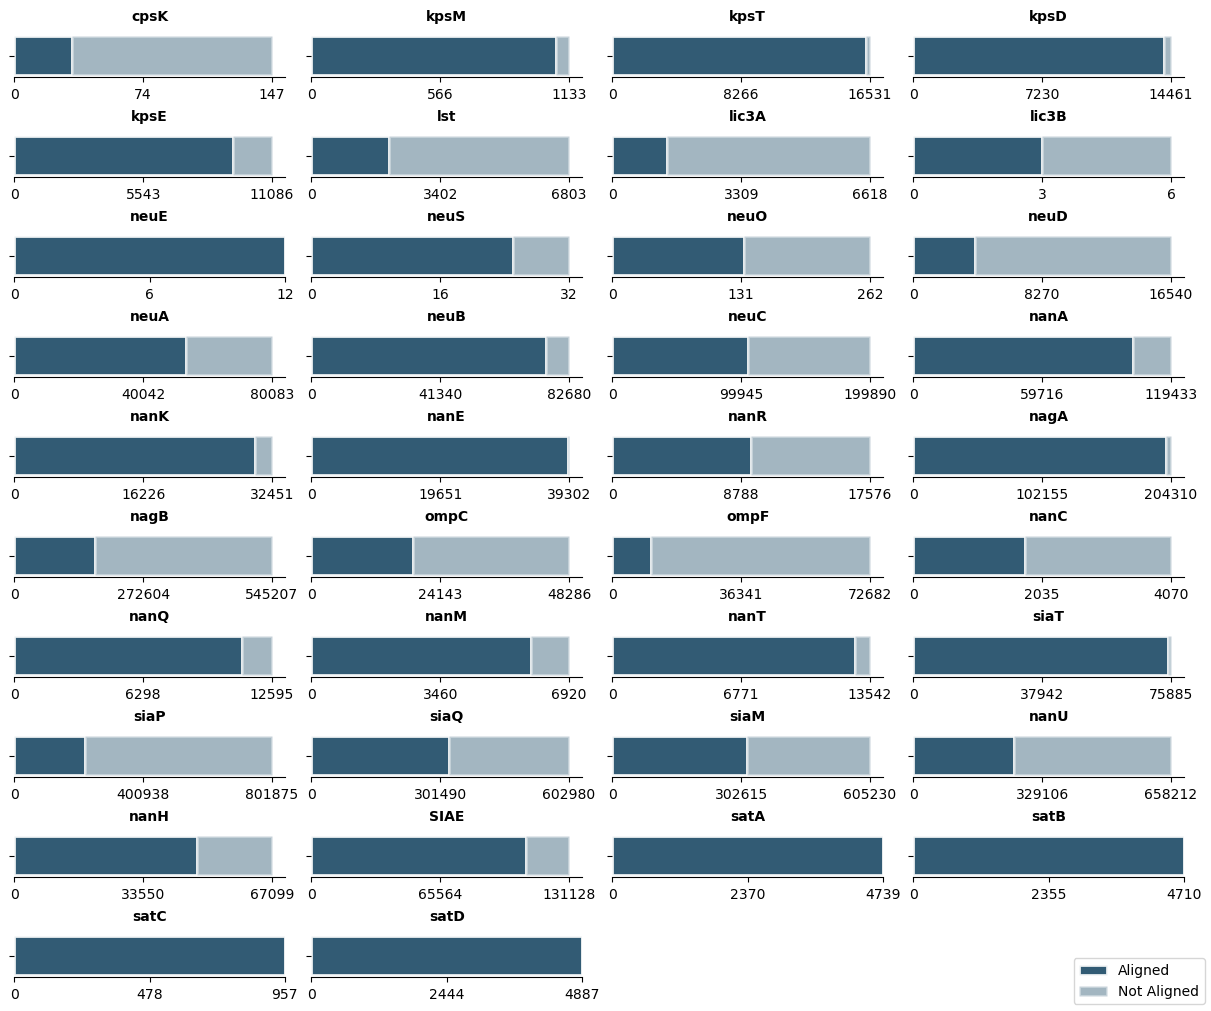

In [3]:
df = pd.read_csv("/media/Data/thais/sialic_acid_catalog/database/align/alignment_databases_merged/NA/summary.csv")

# Number of plots
n = len(df)
ncols = 4
nrows = math.ceil(n / ncols)

# Create figure
fig, axes = plt.subplots(
    nrows, ncols,
    figsize=(ncols*3, nrows*1),
    constrained_layout=True
)
axes = axes.flatten()

# Define colors
cor = "#1b4965"          # Solid blue

for i, row in df.iterrows():
    gene = row["gene"]
    total = row["total_sequences"]
    aligned = row["aligned"]
    not_aligned = row["not_aligned"]

    # Stacked horizontal bar plot
    axes[i].barh(0, aligned, label="Aligned", height=0.15, color=cor, alpha=0.9, edgecolor='white', linewidth=2)
    axes[i].barh(0, not_aligned, left=aligned, label="Not Aligned", height=0.15, color=cor, alpha=0.4, edgecolor='white', linewidth=2)
    
    # Plot settings
    axes[i].set_yticks([0])
    axes[i].set_yticklabels([""])
    axes[i].set_title(gene, fontsize=10, fontweight="bold", pad=10)
    
    # Define X-axis ticks (minimum, midpoint, maximum)
    meio = (total) / 2
    axes[i].set_xticks([0, meio, total])
    axes[i].set_xticklabels([0, f"{meio:.0f}", f"{total:.0f}"])

    axes[i].spines[['top', 'right', 'left']].set_visible(False)
    
    # Rotate X-axis tick labels
    axes[i].tick_params(axis="x")

# Remove extra axes (if there is leftover space in the grid)
for j in range(i + 1, len(axes)):
    fig.delaxes(axes[j])

# Global legend
handles, labels = axes[0].get_legend_handles_labels()
fig.legend(handles, labels, loc="lower right")

plt.show()